In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 06: Base Model Descriptives
 * Compare the results for Friedman's H, ALE, and Shapley.  
 * Create some descriptive plots to provide more info about some of the findings.

*This script takes about 1 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import warnings
import time
import scipy
import random
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
import scipy.sparse as sp

In [3]:
setup.plot_defaults()

## Import Data

##### Predictors

In [4]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv'))['feature'].tolist()

##### Dataset - use sample of training data

In [5]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

##### Model

In [6]:
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

##### Permutation importances

In [7]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

##### Friedman's H Scores

In [8]:
h_comb = pd.read_csv(Path(setup.temp_path).joinpath('03_DATA_h_scores.csv'))

##### 2-Way ALE Mean Abs

In [9]:
ale_mean_abs = pd.read_csv(Path(setup.temp_path).joinpath('04_DATA_ale_magnitudes_2way.csv'))

##### Shapley Interaction Mean Abs

In [10]:
shap_mean_abs = pd.read_csv(Path(setup.temp_path).joinpath('05_DATA_shap_mean_abs.csv'))

## Compare Ranks for the Three Methods

##### Align ranks and save table

In [11]:
h_comb['rank'] = h_comb['h_score'].rank(method='first', ascending=False) 
h_comb = h_comb.rename(columns={'h_score':'score'})

In [12]:
ale_mean_abs['rank'] = ale_mean_abs['abs_mean'].rank(method='first', ascending=False)
ale_mean_abs = ale_mean_abs.rename(columns={'abs_mean':'score'})

In [13]:
shap_mean_abs_int = shap_mean_abs[shap_mean_abs['feat_1'] != shap_mean_abs['feat_2']] \
    .copy() \
    .rename(columns={'shap_mean_abs':'score'})
shap_mean_abs_int['rank'] = shap_mean_abs_int['score'].rank(method='first', ascending=False)

In [14]:
rank_comb = h_comb[['rank', 'score', 'label']] \
    .merge(ale_mean_abs[['rank', 'score', 'label']], how='outer', on='rank',
           suffixes=('_h', '_ale')) \
    .merge(shap_mean_abs_int[['rank', 'score', 'label']], how='outer', on='rank') \
    .rename(columns={'score':'score_shap', 'label':'label_shap'})

In [15]:
rank_comb.head()

,rank,score_h,label_h,score_ale,label_ale,score_shap,label_shap
0,1.0,0.234603,loan_amnt:revol_bal,0.010546,int_rate:home_ownership__RENT,0.028876,int_rate:term
1,2.0,0.178645,revol_bal:verification_status,0.010008,int_rate:term,0.018180,int_rate:loan_amnt
2,3.0,0.171378,loan_amnt:annual_inc,0.009111,int_rate:loan_amnt,0.017503,int_rate:sec_app_fico_range_low
3,4.0,0.169135,num_actv_bc_tl:revol_bal,0.008109,annual_inc:sec_app_fico_range_low,0.012391,int_rate:annual_inc
4,5.0,0.128730,home_ownership__RENT:num_actv_bc_tl,0.007709,int_rate:annual_inc,0.010616,int_rate:mort_acc


In [16]:
rank_comb.to_csv(Path(setup.temp_path).joinpath('06_REPORT_top_interactions_all.csv'),
                   index=False)

##### Correlations among ranks and with perturbation importances

In [17]:
# Merge ranked data by feature

In [18]:
comb_score_by_feature = h_comb[['rank', 'score', 'label', 'feat_1', 'feat_2']] \
    .merge(ale_mean_abs[['rank', 'score', 'feat_1', 'feat_2']], how='outer', 
           on=['feat_1', 'feat_2'],suffixes=('_h', '_ale')) \
    .merge(shap_mean_abs_int[['rank', 'score', 'feat_1', 'feat_2']], how='outer', 
           on=['feat_1', 'feat_2']) \
    .rename(columns={'score':'score_shap', 'rank':'rank_shap'})

In [19]:
# Append permutation feature importances
comb_score_by_feature = comb_score_by_feature.merge(perm_importance_df[['features', 'abs_importance']] \
                                      .rename(columns={'abs_importance':'pi_1_a'}),
                                  how='left', left_on='feat_1', right_on='features') \
    .drop(columns=['features']) \
    .merge(perm_importance_df[['features', 'abs_importance']] \
                                      .rename(columns={'abs_importance':'pi_2_a'}),
                                  how='left', left_on='feat_2', right_on='features') \
    .drop(columns=['features']) 

In [20]:
# Reorder permutation importances by strength
comb_score_by_feature['pi_1'] = np.where(comb_score_by_feature['pi_1_a'] >=  comb_score_by_feature['pi_2_a'],
                                   comb_score_by_feature['pi_1_a'], comb_score_by_feature['pi_2_a'])
comb_score_by_feature['pi_2'] = np.where(comb_score_by_feature['pi_1_a'] >=  comb_score_by_feature['pi_2_a'],
                                   comb_score_by_feature['pi_2_a'], comb_score_by_feature['pi_1_a'])
comb_score_by_feature.drop(columns=['pi_1_a', 'pi_2_a'], inplace=True)

In [21]:
comb_score_by_feature.sort_values('rank_ale').head()

,rank_h,score_h,label,feat_1,feat_2,rank_ale,score_ale,rank_shap,score_shap,pi_1,pi_2
35,36.0,0.039198,int_rate:home_ownership__RENT,int_rate,home_ownership__RENT,1.0,0.010546,10.0,0.007944,0.003413,0.000759
8,9.0,0.101609,int_rate:term,int_rate,term,2.0,0.010008,1.0,0.028876,0.003413,0.001203
18,19.0,0.074452,int_rate:loan_amnt,int_rate,loan_amnt,3.0,0.009111,2.0,0.018180,0.003413,0.001010
27,28.0,0.055974,annual_inc:sec_app_fico_range_low,annual_inc,sec_app_fico_range_low,4.0,0.008109,30.0,0.004214,0.000983,0.000742
33,34.0,0.041471,int_rate:annual_inc,int_rate,annual_inc,5.0,0.007709,4.0,0.012391,0.003413,0.000983


In [22]:
# Correlations
comb_score_corr  = comb_score_by_feature[['score_h', 'score_ale', 'score_shap', 'pi_1', 'pi_2']].corr(method='spearman')

In [23]:
comb_score_corr

,score_h,score_ale,score_shap,pi_1,pi_2
score_h,1.000000,0.095125,0.347036,-0.334086,-0.032902
score_ale,0.095125,1.000000,0.637681,0.546287,0.720390
score_shap,0.347036,0.637681,1.000000,0.544101,0.762723
pi_1,-0.334086,0.546287,0.544101,1.000000,0.467320
pi_2,-0.032902,0.720390,0.762723,0.467320,1.000000


In [24]:
comb_score_corr.to_csv(Path(setup.temp_path).joinpath('06_REPORT_interactions_corr.csv'),
                   index=True)

## Term and Interest Rate
This is an interaction which shows opposite yet similar effects with SHAP vs. ALE.  Get more information about these features and how the model responds to them.

### Correlations between term and other features

In [25]:
term_corr = pd.DataFrame({'feature': predictor_features,
                          'corr': [train_samp_df[['term', f]] \
                                   .corr().iloc[0,1] for f in predictor_features]})

In [26]:
term_corr.sort_values('corr', ascending=False).head(5)

,feature,corr
1,term,1.000000
2,int_rate,0.420609
0,loan_amnt,0.378657
5,verification_status,0.130195
9,initial_list_status,0.101052


In [27]:
len(train_samp_df[train_samp_df['int_rate'] >= 20]) / len(train_samp_df)

0.08207

In [28]:
train_samp_df['int_rate'].describe()

count    100000.000000
mean         13.245706
std           4.776438
min           5.310000
25%           9.750000
50%          12.740000
75%          15.990000
max          30.990000
Name: int_rate, dtype: float64

In [29]:
train_samp_df['term'].value_counts(normalize=True)

36    0.75712
60    0.24288
Name: term, dtype: float64

### Trees: Relative Importance for Loan Amount, Term 
Get decision paths for low and high interest rate cases, for various terms.  See how often these experience the 'term' feature

### 2-Way plots of actual and predicted rates.
What does the raw data / response show?  Bucket the interest rates and plot the mean term rates / model response for both term values.

In [30]:
# Get model predictions
model_predict = pd.Series(base_model.predict_proba(train_samp_df[predictor_features])[:,1])
model_predict.name = 'predict'

In [31]:
# Append to data
train_pred_df = pd.concat([train_samp_df[['int_rate', 'term', 'target']].reset_index(), 
                           model_predict], axis=1)

In [32]:
# Bucket the interest rates
train_pred_df['int_rate_grp'] = pd.qcut(train_pred_df['int_rate'], 25, duplicates='drop')

In [33]:
# Aggregate
train_samp_agg = train_pred_df.groupby(['int_rate_grp', 'term']) \
    [['target', 'predict']] \
    .agg(['mean', 'std']) 
train_samp_agg.columns = [c[0]+'_' + c[1] for c in train_samp_agg.columns]
train_samp_agg.reset_index(inplace=True)

In [34]:
# Add interest rate midpoints for plotting
train_samp_agg['plot_x'] = train_samp_agg['int_rate_grp'].apply(lambda x: float(x.mid))

In [35]:
train_samp_agg_plot = train_samp_agg[['plot_x', 'term', 'target_mean', 'predict_mean']] \
    .pivot(index='plot_x', columns='term', values=['target_mean', 'predict_mean'])

In [36]:
# Colors array for plot
cmap = mpl.cm.coolwarm
n = len(train_samp_agg['term'].value_counts())
colors = cmap(np.linspace(0,1,n))


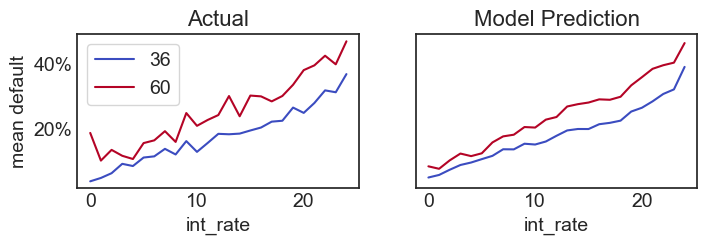

In [37]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
figsize=(8,2)
    
train_samp_agg_plot[[c for c in train_samp_agg_plot.columns if c[0] == 'target_mean']] \
    .droplevel(0, axis=1) \
    .plot(color=colors, legend=None, figsize=figsize, ax=ax[0])
train_samp_agg_plot[[c for c in train_samp_agg_plot.columns if c[0] == 'predict_mean']] \
    .droplevel(0, axis=1) \
    .plot(color=colors, legend=None, figsize=figsize, ax=ax[1])     

ax[0].legend(frameon=True)
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax[1].set_xlabel('int_rate')
ax[0].set_xlabel('int_rate')
ax[0].set_ylabel('mean default')
ax[0].title.set_text('Actual')
ax[1].title.set_text('Model Prediction')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_actual_pred.png'),
            bbox_inches='tight')

### Inspect Trees
 * Get general stats about nodes involving interest rate and term
 * Get information about whether higher term leads to higher predictions, at low vs. high interest rates.

In [38]:
# Get the indices of our features of interest - int_rate and term

In [39]:
term_index = predictor_features.index('term')

In [40]:
int_rate_index = predictor_features.index('int_rate')

In [41]:
# get the estimators

In [42]:
base_model_est = base_model.estimators_

In [43]:
len(base_model_est)

20

### Overall Tree Stats
Count nodes for interest rates and term, and see whether any low term values lead to higher predictions

##### Function to get tree stats

In [44]:
def get_tree_stats(tree, node_id = 0, 
                   info_ary = np.array([0, 0, 0, 0, 0]),
                   int_rate_index = int_rate_index,
                   term_index = term_index):
    """ Traverses the tree, counting nodes of various types.
    Recursive function.  Usualy you willl not modify node_id or
    info_ary; these are used during recursion.
      Inputs:
        tree:  The tree to traverse (estimator)
        node_id: Starting node for counting.  0 indicates the root,
        info_ary:  Start counts of various nodes.  See "Value".
          Leave as arrays of 0 to count items at or below node_id
        int_rate_index: Integer index of the interest rate variable; needed
            as the trees do not include feature names.
        term_index: Integer index of the term variable
      Value:  Numpy array containing tree information.  The 5 items are:
        total nodes
        total nodes for the interest rate feature
        total nodes for the term feature
        total nodes for the term feature, where the left value is larger
        total nodes for the term feature, where the right value is larger
    """ 
    
    info_ary = info_ary.copy()
    
    # Count nodes
    info_ary[0] += 1
    
    # Get children
    this_left = tree.tree_.children_left[node_id]
    this_right = tree.tree_.children_right[node_id]
    
    # If a leaf node, return
    if this_left == this_right:
        return info_ary
    
    this_feature = tree.tree_.feature[node_id]
    
    if (this_feature == int_rate_index):
        info_ary[1] += 1
    elif (this_feature == term_index):
        info_ary[2] += 1
        value_left = tree.tree_.value[this_left][0][0]
        value_right = tree.tree_.value[this_right][0][0]
        if value_left >= value_right:
            info_ary[3] += 1
        else:
            info_ary[4] += 1
        
    # Helper function to pass most features to the next node
    def return_node(node_id):
        return get_tree_stats(tree, node_id, 
                   info_ary = info_ary,
                   int_rate_index = int_rate_index,
                   term_index = term_index)
    
    # Traverse tree both ways
    return return_node(this_left) + \
            return_node(this_right)
                

##### Get stats for all trees

In [45]:
tree_stats = pd.concat([pd.DataFrame(get_tree_stats(e)).T \
                        .set_axis(['tot_node', 'int_rate_node', 
                                   'term_node',  'term_node_left', 'term_node_right'], 
                                  axis=1) \
                        for e in base_model_est[:,0]], 
                       axis=0, keys = range(0, len(base_model_est))) \
    .reset_index(level=0, drop=False) \
    .rename(columns={'level_0': 'tree_index'}) \
    .reset_index(drop=True)
                       

In [46]:
tree_stats.head(3)

,tree_index,tot_node,int_rate_node,term_node,term_node_left,term_node_right
0,0,192,86,24,0,24
1,1,192,78,24,0,24
2,2,192,82,16,0,16


In [47]:
tree_stats.to_csv(Path(setup.temp_path).joinpath('06_REPORT_tree_stats_all.csv'),
                  index=False)

In [48]:
tree_stats_summary = tree_stats.describe()
tree_stats_summary

,tree_index,tot_node,int_rate_node,term_node,term_node_left,term_node_right
count,20.00000,20.000000,20.000000,20.000000,20.0,20.000000
mean,9.50000,185.550000,42.850000,10.050000,0.0,10.050000
std,5.91608,13.315899,27.722829,8.864328,0.0,8.864328
min,0.00000,145.000000,2.000000,0.000000,0.0,0.000000
25%,4.75000,185.000000,17.000000,2.000000,0.0,2.000000
50%,9.50000,192.000000,41.000000,8.000000,0.0,8.000000
75%,14.25000,192.000000,63.500000,17.250000,0.0,17.250000
max,19.00000,192.000000,86.000000,24.000000,0.0,24.000000


In [49]:
tree_stats_summary.to_csv(Path(setup.temp_path).joinpath('06_REPORT_tree_stats_summary.csv'),
                  index=True)

### Trees: Relative Importance for Loan Amount, Term 
Get decision paths for low and high interest rate cases, for various terms.  See how often these experience the 'term' feature

In [50]:
# Function to get the value difference for the nodes involving a
# feature.  Get the mean per path.

In [51]:
def path_value_diff(tree, decision_paths,
                     feature_index = term_index):
    """ For decision paths in a tree, find the first node involving
    a specified feature, if any.  Then, find the change in value
    for the left and right paths after that split"""
    
    # Flag nodes involving the feature in the tree:
    feature_nodes = (tree.tree_.feature == feature_index)
    
    # Repeat the matrix to match the number of decision paths
    feature_nodes_mat = np.asmatrix(np.repeat(feature_nodes, 
                                              decision_paths.shape[0], 0) \
        .reshape((feature_nodes.shape[0], decision_paths.shape[0])).T)
    
    # Element-wise multiplication to get nodes in the decision paths
    # involving the feature
    decision_paths_mask = decision_paths.multiply(feature_nodes_mat)
    found_ind = sp.find(decision_paths_mask == 1)
    
    # Convert to a data frame
    found_df = pd.DataFrame({'ind':found_ind[0], 'node':found_ind[1]}) \
        .sort_values('ind')
    
    # Get the splits
    found_df['val_left'] = found_df['node'] \
        .apply(lambda x: tree.tree_.value[tree.tree_.children_left[x]][0][0])
    found_df['val_right'] = found_df['node'] \
        .apply(lambda x: tree.tree_.value[tree.tree_.children_right[x]][0][0])
    found_df['val_diff'] = found_df['val_right']  - found_df['val_left']
    
    # Get the number of samples reaching this node
    found_df['node_samp'] = found_df['node'] \
        .apply(lambda x: tree.tree_.n_node_samples[x])
    
    # Get mean per path
    found_agg = found_df.groupby('ind')[['val_diff', 'node_samp']].apply('max')
    
    return found_agg

    

In [52]:
# Function to get decision path information for a tree

In [53]:
def decision_path_counter(tree, X,
                          int_rate_index = int_rate_index,
                         term_index = term_index):
    """ Looks at decision paths in a tree for a dataset, and
    counts the number of times the interest rate and term features
    occur for each observation.  Also returns some overall tree stats
    """
    
    # Get features of interest
    int_rate_features = (tree.tree_.feature == int_rate_index)
    term_features = (tree.tree_.feature == term_index)
    
    # Get the decision paths for the observations in X
    decision_paths = tree.decision_path(X)
    
    # Count nodes of each type
    node_count_int_rate = decision_paths * int_rate_features
    node_count_term = decision_paths * term_features
    
    # Convert to a series
    count_df = pd.concat([pd.Series(node_count_int_rate).rename('int_rate_traversed'),
                          pd.Series(node_count_term).rename('term_traversed')],
                         axis=1)
    
    # Append overall tree information
    count_df['int_rate_total'] = np.sum(int_rate_features)
    count_df['term_total'] = np.sum(term_features)
    count_df['total_nodes'] = tree.tree_.node_count
    
    # Find split info for term
    term_split_val = path_value_diff(tree, decision_paths, term_index)
    
    count_df = count_df.merge(term_split_val, left_index = True, right_index=True,
                             how='left')

    return count_df

In [54]:
# Get stats for all trees

In [55]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    node_counts = pd.concat([decision_path_counter(e, train_samp_df[predictor_features]) \
                             for e in base_model_est[:,0]], axis=0,
                            keys = range(0, len(base_model_est))) \
        .reset_index(level=1, drop=False) \
        .rename(columns={'level_1': 'case_index'}) 

In [56]:
node_counts['val_diff'] = node_counts['val_diff'].fillna(0)
node_counts['node_samp'] = node_counts['node_samp'].fillna(0)

In [57]:
node_counts.head()

,case_index,int_rate_traversed,term_traversed,int_rate_total,term_total,total_nodes,val_diff,node_samp
0,0,2,1,10,3,63,0.063854,68264.0
0,1,2,1,10,3,63,0.063854,68264.0
0,2,3,1,10,3,63,0.111085,39073.0
0,3,3,0,10,3,63,0.000000,0.0
0,4,3,1,10,3,63,0.111085,39073.0


In [58]:
node_counts.shape

(2000000, 8)

In [59]:
node_counts_tot = node_counts.groupby('case_index')\
    .agg('mean')

In [60]:
node_counts_tot.shape

(100000, 7)

In [61]:
dec_path_info_merge = pd.concat([train_samp_df[['int_rate', 'term']], node_counts_tot], axis=1)

In [62]:
dec_path_info_merge['int_rate_q'] = pd.cut(dec_path_info_merge['int_rate'], 25)
dec_path_info_merge['int_rate_q'] = dec_path_info_merge['int_rate_q'].apply(lambda x: x.mid) \
    .astype('float')

In [63]:
dec_path_agg = dec_path_info_merge.groupby(['int_rate_q', 'term']) \
    .agg('mean') \
    .reset_index()

<AxesSubplot: xlabel='int_rate', ylabel='node_samp'>

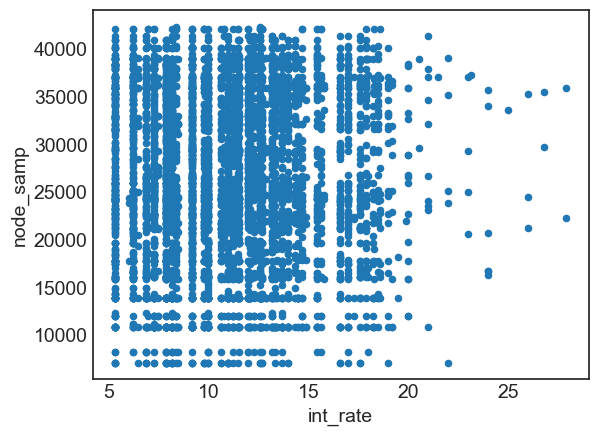

In [64]:
dec_path_info_merge[dec_path_info_merge['term'] ==36].plot(x='int_rate', y='node_samp',
                                                           kind='scatter')

<AxesSubplot: xlabel='int_rate', ylabel='node_samp'>

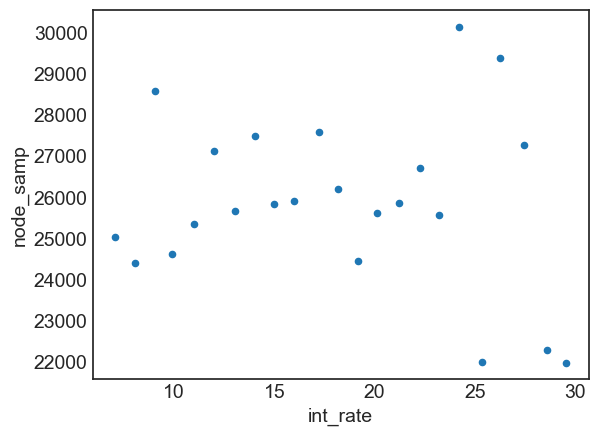

In [65]:
dec_path_agg[dec_path_agg['term'] ==60].plot(x='int_rate', y='node_samp',
                                                           kind='scatter')

In [66]:
type(this_tree.tree_.children_right)

NameError: name 'this_tree' is not defined

In [ ]:
this_tree